<a href="https://colab.research.google.com/github/BuddhikaRoshan/HemoAi/blob/Shamith/Anemic_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub tensorflow scikit-learn matplotlib seaborn pillow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision

import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
path = kagglehub.dataset_download("jocelyndumlao/anerbc-anemia-diagnosis-using-rbc-images")

print("Path to dataset files:", path)

100%|██████████| 7.41G/7.41G [01:25<00:00, 92.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jocelyndumlao/anerbc-anemia-diagnosis-using-rbc-images/versions/1


In [ ]:
import os

# List everything in the dataset root
dataset_root = path
print("Contents of dataset root:", os.listdir(dataset_root))

# If there's a single folder inside, go one level deeper
for item in os.listdir(dataset_root):
    item_path = os.path.join(dataset_root, item)
    if os.path.isdir(item_path):
        print(f"Contents of {item}:", os.listdir(item_path))


Contents of dataset root: ['AneRBC dataset a benchmark dataset for computer-aided anemia diagnosis using RBC images. httpsdoi.org10.1093databasebaae120']
Contents of AneRBC dataset a benchmark dataset for computer-aided anemia diagnosis using RBC images. httpsdoi.org10.1093databasebaae120: ['AneRBC_dataset']


In [ ]:
# Correct dataset path
dataset_folder = os.path.join(path,
    "AneRBC dataset a benchmark dataset for computer-aided anemia diagnosis using RBC images. httpsdoi.org10.1093databasebaae120",
    "AneRBC_dataset"
)

# Check what’s inside
print("Contents of AneRBC_dataset:", os.listdir(dataset_folder))


Contents of AneRBC_dataset: ['upload_data_for_training.ipynb', 'AneRBC-II', 'AneRBC-I', 'readme.txt']


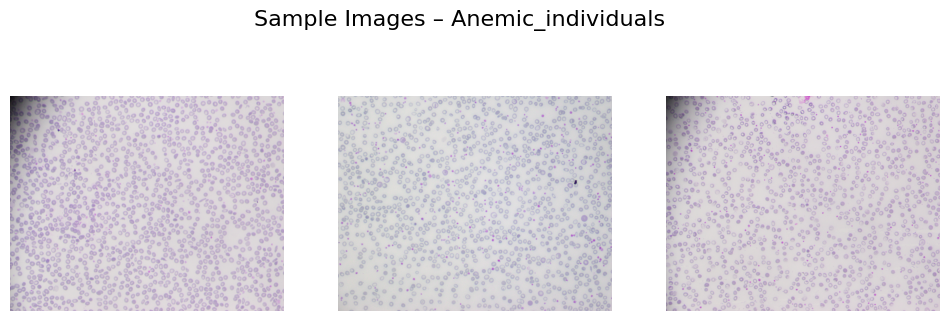

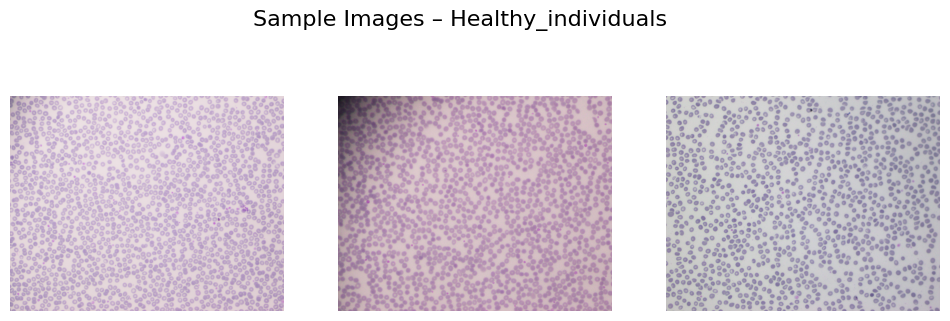

In [ ]:
# Assuming dataset_folder is defined correctly from previous cells
train_data_root = os.path.join(dataset_folder, "AneRBC-I") # Use AneRBC-I for training data

classes = os.listdir(train_data_root)

for cls in classes:
    # Adjusted to go one level deeper for image files into 'Original_images' subdirectory
    # Change 'Original_images' to 'RGB_segmented' if you prefer segmented images
    img_dir = os.path.join(train_data_root, cls, 'Original_images')

    # Check if the image directory exists
    if not os.path.isdir(img_dir):
        print(f"Image directory not found: {img_dir} for class: {cls}")
        continue

    images = [
        f for f in os.listdir(img_dir)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    # Skip if no images are found for the current class to prevent IndexError
    if not images:
        print(f"No image files found in {img_dir} for class: {cls}")
        continue

    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    fig.suptitle(f"Sample Images – {cls}", fontsize=16)

    for i in range(3):
        if not images:
            break # Break if we run out of images for this class
        img_path = os.path.join(img_dir, random.choice(images))
        img = Image.open(img_path)
        ax[i].imshow(img)
        ax[i].axis('off')

    plt.show()

In [ ]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
NUM_CLASSES = 2

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dir = os.path.join(dataset_folder, "AneRBC-I")
test_dir = os.path.join(dataset_folder, "AneRBC-II")

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
NUM_CLASSES = 2  # binary classification

base_model = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=(160,160,3)
)
base_model.trainable = False  # freeze base for transfer learning

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')  # 2 classes
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 5, 5, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,088,658 (23.23 MB)

 Trainable params: 166,786 (651.51 KB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [ ]:
callbacks = [EarlyStopping(patience=3, restore_best_weights=True)]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 355s 5s/step - accuracy: 0.4955 - loss: 0.8534 - val_accuracy: 0.5033 - val_loss: 0.6954
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - accuracy: 0.5159 - loss: 0.7832 - val_accuracy: 0.5233 - val_loss: 0.6966
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - accuracy: 0.5296 - loss: 0.7677 - val_accuracy: 0.4033 - val_loss: 0.6974
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 328s 4s/step - accuracy: 0.5082 - loss: 0.7486 - val_accuracy: 0.4283 - val_loss: 0.6974


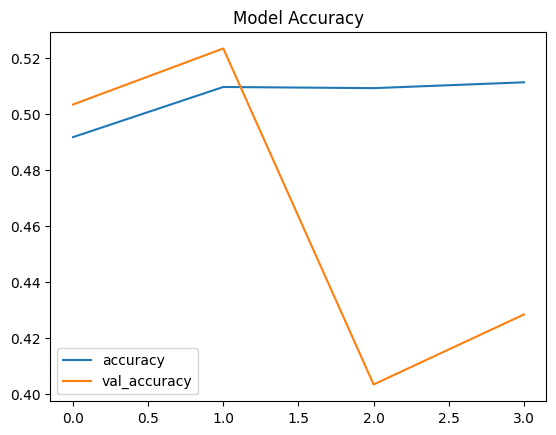

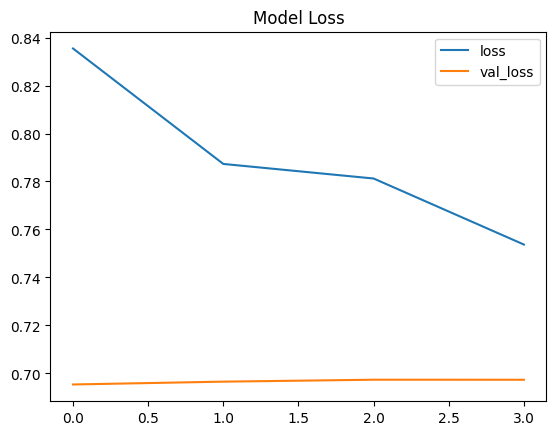

In [ ]:
# -----------------------------------------------------------
# Plot Accuracy and Loss
# -----------------------------------------------------------
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Model Accuracy")
plt.show()

history_df.loc[:, ['loss', 'val_loss']].plot(title="Model Loss")
plt.show()

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-40]:
    layer.trainable = False

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1238s 16s/step - accuracy: 0.4821 - loss: 1.0438 - val_accuracy: 0.5900 - val_loss: 0.6822
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1212s 16s/step - accuracy: 0.5091 - loss: 0.9054 - val_accuracy: 0.4733 - val_loss: 0.6902
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1210s 16s/step - accuracy: 0.5130 - loss: 0.9072 - val_accuracy: 0.5067 - val_loss: 0.6946
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1215s 16s/step - accuracy: 0.4880 - loss: 0.9357 - val_accuracy: 0.5183 - val_loss: 0.6909


In [ ]:
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

Found 36000 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3118s 3s/step - accuracy: 0.2776 - loss: 0.8314
Test Accuracy: 0.511305570602417


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3131s 3s/step


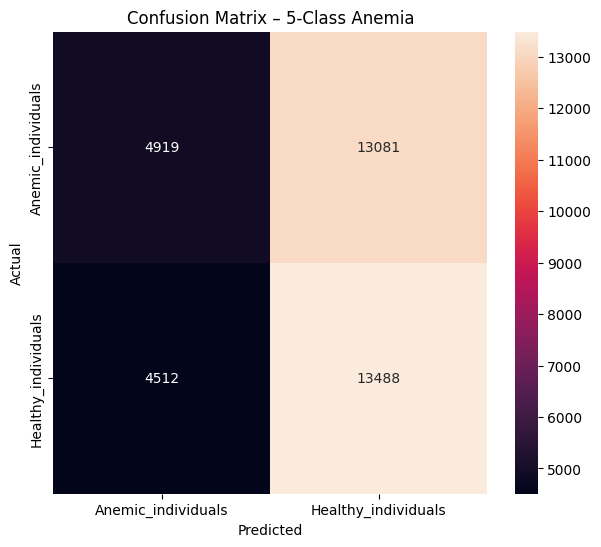

In [ ]:
y_prob = model.predict(test_gen)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes

class_names = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – 5-Class Anemia")
plt.show()
